In [1]:
import pandas as pd
import sys
import os
import importlib
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Configurar el path para poder importar tools
# El notebook está en ENTREGABLES/lorenn/, necesitamos subir un nivel a ENTREGABLES/
current_dir = os.getcwd()
# Si estamos en lorenn/, subir un nivel
if current_dir.endswith('lorenn'):
    entregables_dir = os.path.dirname(current_dir)
else:
    # Si no, buscar el directorio ENTREGABLES en el path actual
    entregables_dir = current_dir
    while not os.path.exists(os.path.join(entregables_dir, 'tools.py')):
        parent = os.path.dirname(entregables_dir)
        if parent == entregables_dir:  # Llegamos a la raíz
            break
        entregables_dir = parent

if os.path.exists(os.path.join(entregables_dir, 'tools.py')):
    if entregables_dir not in sys.path:
        sys.path.insert(0, entregables_dir)
    print(f"✅ Path configurado: {entregables_dir}")
else:
    print("⚠️ No se encontró el archivo tools.py. Verifica la estructura del proyecto.")

# Importar y recargar el módulo tools para asegurar que tenemos la versión más reciente
import tools
importlib.reload(tools)  # Recargar el módulo para obtener los cambios más recientes
from tools import (
    seleccionar_variables, 
    plot_costo_interactivo, 
    evaluate_model_with_thresholds, 
    evaluate_model,
    optimizar_threshold_costo_cv,
    optimizar_threshold_f1_cv
)

print("✅ Módulo tools recargado e importado correctamente")


✅ Path configurado: c:\Users\marca\OneDrive\AUSTRAL\2do año\2do cuat\TRP II\mercado-libre-fraude-2025\ENTREGABLES
✅ Módulo tools recargado e importado correctamente


In [2]:
df = pd.read_csv("../../DATA/processed/fraud_dataset_processed.csv")

df = seleccionar_variables(
    df,
    categoria_encoding=True, 
    pais_encoding=True,
    o_dummies=True,
    producto_nombre_encoding=True,
    fecha_encoding=3,
    usar_imputadas=True,
    remove_r = True,
    remove_d=True,
    remove_score=True
    )


Columnas reemplazadas por versiones imputadas: b, c, f, l, m, q


In [3]:
# ============================================================================
# PIPELINE COMPLETO DEL MODELO
# ============================================================================
# 1. Preparar datos
# 2. Entrenar modelos (uno con CV para optimizar thresholds, otro con todos los datos)
# 3. Optimizar thresholds (costo y F1) con CV
# 4. Evaluar modelo con ambos thresholds
# ============================================================================

# Preparar variables predictoras y target
X = df.drop(columns=['fraude'])
y = df['fraude']

# Split en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("=" * 80)
print("PASO 1: ENTRENAR MODELOS")
print("=" * 80)

# Configurar Linear SVM
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC

# Usar SVC con kernel lineal y probability=True para obtener predict_proba
svm_cv = SVC(kernel='linear', random_state=42, class_weight='balanced', probability=True, max_iter=200)
svm_final = SVC(kernel='linear', random_state=42, class_weight='balanced', probability=True, max_iter=200)

# Configurar Cross-Validation (5 folds estratificados)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\n✅ Modelos configurados:")
print(f"   - svm_cv: Para optimización de thresholds con CV")
print(f"   - svm_final: Para evaluación final con todos los datos de entrenamiento")

# Entrenar modelo final con todos los datos de entrenamiento (para evaluación)
print(f"\n🎯 Entrenando modelo final con todos los datos de entrenamiento...")
svm_final.fit(X_train, y_train)

# Predicciones en el conjunto de test
y_proba_test = svm_final.predict_proba(X_test)[:, 1]

print(f"\n✅ Modelo final entrenado")
print(f"   - Probabilidades en test: {len(y_proba_test)} muestras")


PASO 1: ENTRENAR MODELOS

✅ Modelos configurados:
   - svm_cv: Para optimización de thresholds con CV
   - svm_final: Para evaluación final con todos los datos de entrenamiento

🎯 Entrenando modelo final con todos los datos de entrenamiento...

✅ Modelo final entrenado
   - Probabilidades en test: 50000 muestras


In [4]:
# ============================================================================
# PASO 2: OPTIMIZAR THRESHOLDS CON CROSS-VALIDATION
# ============================================================================

print("=" * 80)
print("PASO 2: OPTIMIZAR THRESHOLDS CON CROSS-VALIDATION")
print("=" * 80)

# Parámetros de costo
costo_fp = 5.0
costo_fn = 100.0

# Calcular probabilidades de CV una sola vez (para evitar recalcular los folds)
print("\n📊 Calculando probabilidades con Cross-Validation...")
from sklearn.model_selection import cross_val_predict
y_proba_cv = cross_val_predict(svm_cv, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
print(f"✅ Probabilidades de CV calculadas: {len(y_proba_cv)} muestras")

# Optimizar threshold por costo usando CV
print("\n🔍 Optimizando threshold por función de costo...")
resultado_costo = optimizar_threshold_costo_cv(
    model=svm_cv,
    X=X_train,
    y=y_train,
    cv=cv,
    costo_fp=costo_fp,
    costo_fn=costo_fn,
    model_name="Linear SVM",
    y_proba_cv=y_proba_cv  # Reutilizar las probabilidades ya calculadas
)

threshold_optimo_costo = resultado_costo['threshold_optimo']
costo_minimo = resultado_costo['costo_minimo']

# Optimizar threshold por F1 Score usando CV
print("\n🔍 Optimizando threshold por F1 Score...")
resultado_f1 = optimizar_threshold_f1_cv(
    model=svm_cv,
    X=X_train,
    y=y_train,
    cv=cv,
    model_name="Linear SVM",
    y_proba_cv=y_proba_cv  # Reutilizar las probabilidades ya calculadas
)

threshold_optimo_f1 = resultado_f1['threshold_optimo']
f1_maximo = resultado_f1['f1_maximo']

print("\n" + "=" * 80)
print("RESUMEN DE THRESHOLDS ÓPTIMOS:")
print("=" * 80)
print(f"📌 Threshold óptimo (Costo): {threshold_optimo_costo:.4f}")
print(f"   Costo mínimo: {costo_minimo:.2f} por 1000 registros")
print(f"\n📌 Threshold óptimo (F1 Score): {threshold_optimo_f1:.4f}")
print(f"   F1 Score máximo: {f1_maximo:.4f}")


PASO 2: OPTIMIZAR THRESHOLDS CON CROSS-VALIDATION

📊 Calculando probabilidades con Cross-Validation...
✅ Probabilidades de CV calculadas: 200000 muestras

🔍 Optimizando threshold por función de costo...

🎯 OPTIMIZACIÓN DE THRESHOLD POR COSTO (CV):
   Threshold óptimo: 0.0454
   Costo mínimo por 1000 registros: 2999.67
   FP ajustado: 7
   FN ajustado: 5999

📊 EVALUACIÓN DE ROBUSTEZ:
   Coeficiente de variación (CV): 0.0009
   Robustez: Muy robusto ✅
   Costo medio por fold: 2999.68 ± 2.65

🔍 Optimizando threshold por F1 Score...

🎯 OPTIMIZACIÓN DE THRESHOLD POR F1 SCORE (CV):
   Threshold óptimo: 0.0154
   F1 Score máximo: 0.0583
   Precision: 0.0301
   Recall: 0.9802

📊 EVALUACIÓN DE ROBUSTEZ:
   Coeficiente de variación (CV): 0.0026
   Robustez: Muy robusto ✅
   F1 Score medio por fold: 0.0583 ± 0.0002

RESUMEN DE THRESHOLDS ÓPTIMOS:
📌 Threshold óptimo (Costo): 0.0454
   Costo mínimo: 2999.67 por 1000 registros

📌 Threshold óptimo (F1 Score): 0.0154
   F1 Score máximo: 0.0583


PASO 3: EVALUAR MODELO CON THRESHOLDS ÓPTIMOS

EVALUACIÓN CON THRESHOLD ÓPTIMO (COSTO)
EVALUACIÓN DEL MODELO: Linear SVM - Threshold Costo (0.0454)

📌 Threshold usado: 0.0454

📊 DISTRIBUCIÓN DE CLASES:
   Clase 0 (No Fraude): 48,500 (97.00%)
   Clase 1 (Fraude):    1,500 (3.00%)
   Total:               50,000

🎯 MÉTRICAS PRINCIPALES:
   Accuracy:            0.9700
   F1 Score:            0.0000 ⭐
   Precision:           0.0000
   Recall (Sensitivity): 0.0000
   Specificity:         1.0000
   ROC AUC:             0.6084
   Average Precision:   0.0432

📈 MÉTRICAS ADICIONALES:
   Cohen's Kappa:       0.0000
   Matthews Corr Coef:  0.0000
   NPV:                 0.9700
   False Positive Rate: 0.0000

📊 RESUMEN DE MÉTRICAS CLAVE:
   Precision:          0.0000
   Recall:             0.0000
   F1 Score:           0.0000
   Cohen's Kappa:      0.0000
   Matthews Corr Coef: 0.0000
   Tasa positivos:     0.0000

💰 COSTO:
   Costo por 1000 registros: 3000.00
   (Costo FP: 5.0, Costo FN: 100.0)

🔢

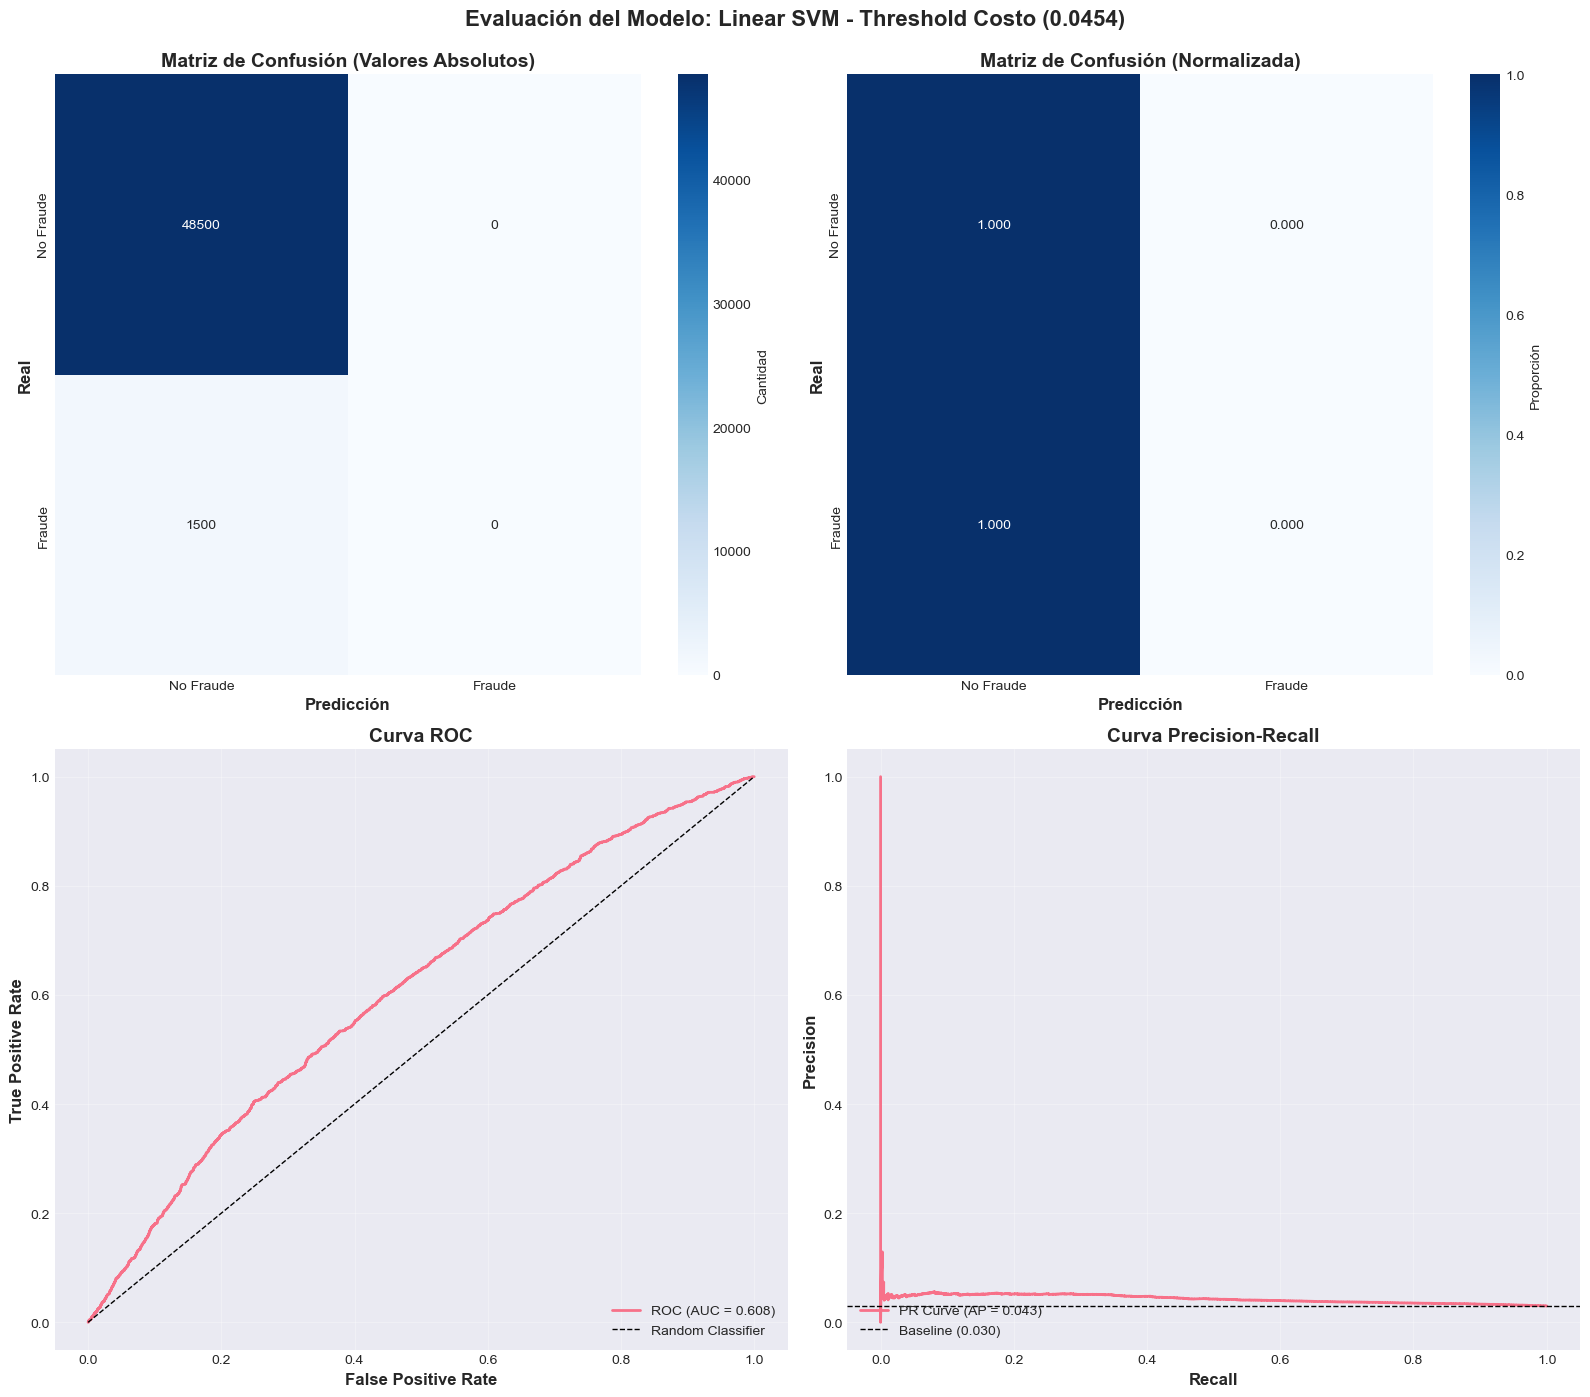

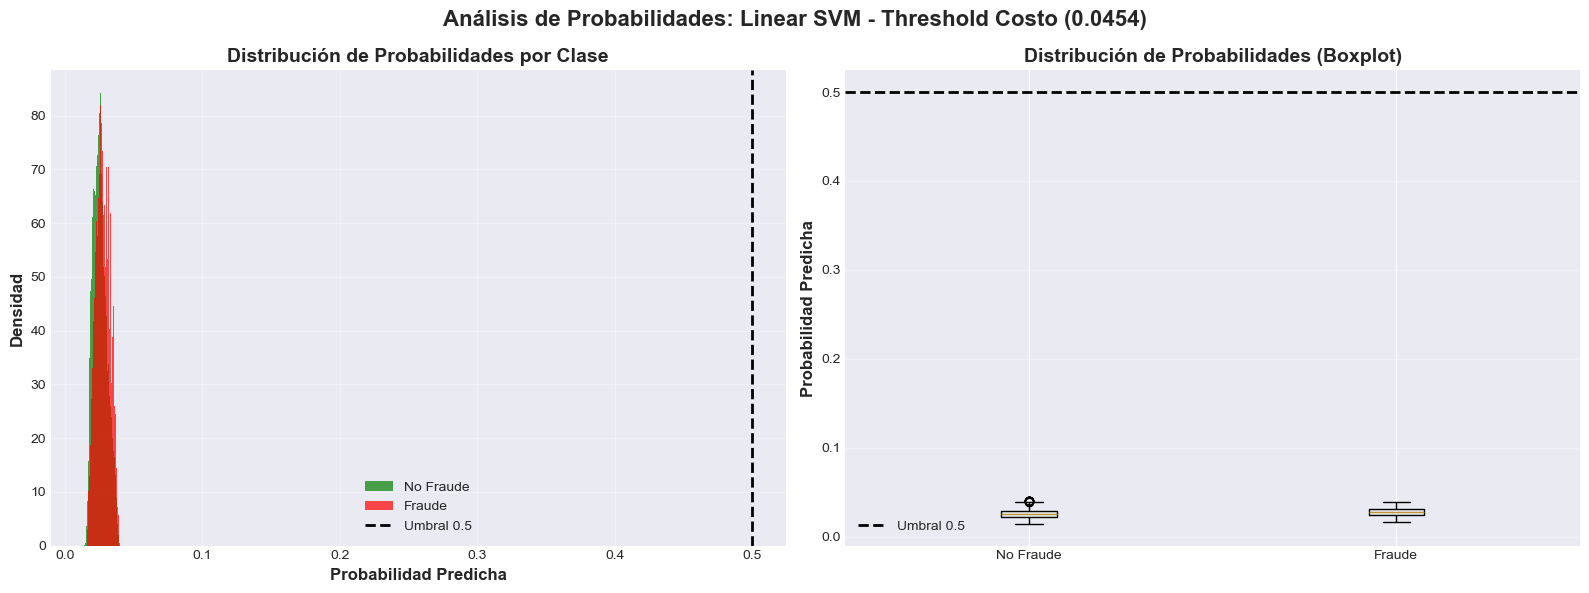


EVALUACIÓN CON THRESHOLD ÓPTIMO (F1 SCORE)
EVALUACIÓN DEL MODELO: Linear SVM - Threshold F1 (0.0154)

📌 Threshold usado: 0.0154

📊 DISTRIBUCIÓN DE CLASES:
   Clase 0 (No Fraude): 48,500 (97.00%)
   Clase 1 (Fraude):    1,500 (3.00%)
   Total:               50,000

🎯 MÉTRICAS PRINCIPALES:
   Accuracy:            0.0303
   F1 Score:            0.0583 ⭐
   Precision:           0.0300
   Recall (Sensitivity): 1.0000
   Specificity:         0.0003
   ROC AUC:             0.6084
   Average Precision:   0.0432

📈 MÉTRICAS ADICIONALES:
   Cohen's Kappa:       0.0000
   Matthews Corr Coef:  0.0031
   NPV:                 1.0000
   False Positive Rate: 0.9997

📊 RESUMEN DE MÉTRICAS CLAVE:
   Precision:          0.0300
   Recall:             1.0000
   F1 Score:           0.0583
   Cohen's Kappa:      0.0000
   Matthews Corr Coef: 0.0031
   Tasa positivos:     0.9997

💰 COSTO:
   Costo por 1000 registros: 4848.40
   (Costo FP: 5.0, Costo FN: 100.0)

🔢 MATRIZ DE CONFUSIÓN:
                    Pred

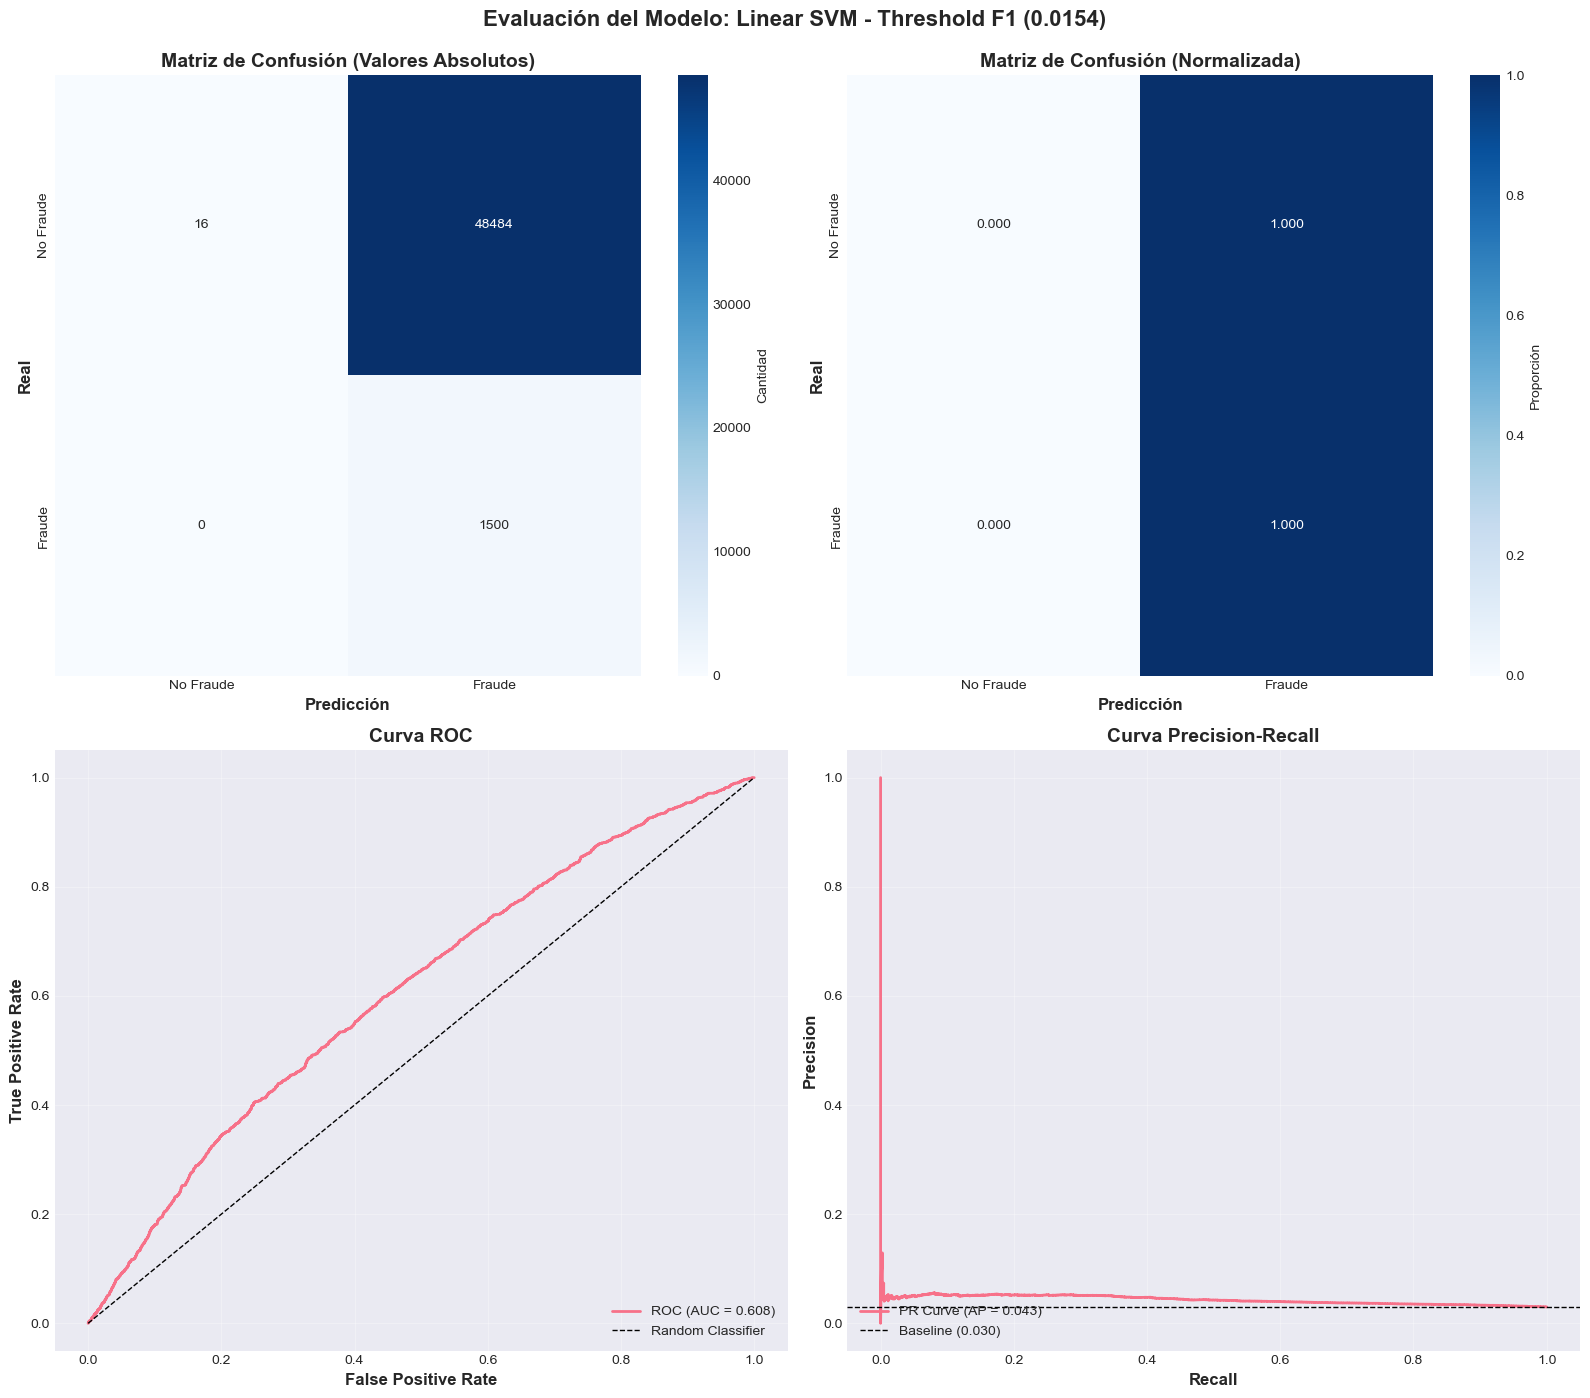

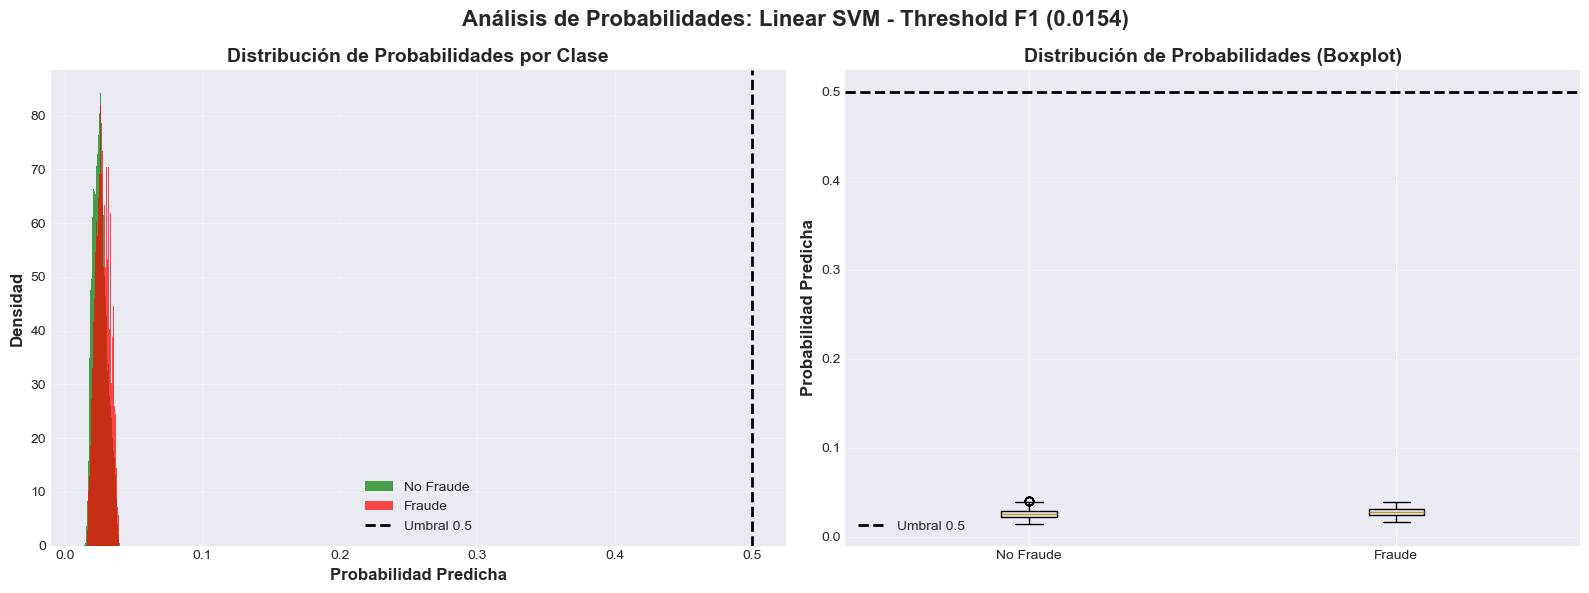

In [5]:
# ============================================================================
# PASO 3: EVALUAR MODELO CON AMBOS THRESHOLDS
# ============================================================================

print("=" * 80)
print("PASO 3: EVALUAR MODELO CON THRESHOLDS ÓPTIMOS")
print("=" * 80)

# Evaluar con threshold óptimo de costo
print("\n" + "=" * 80)
print("EVALUACIÓN CON THRESHOLD ÓPTIMO (COSTO)")
print("=" * 80)

metrics_costo = evaluate_model(
    y_true=y_test,
    y_proba=y_proba_test,
    threshold=threshold_optimo_costo,
    model_name=f"Linear SVM - Threshold Costo ({threshold_optimo_costo:.4f})",
    costo_fp=costo_fp,
    costo_fn=costo_fn
)

# Evaluar con threshold óptimo de F1
print("\n" + "=" * 80)
print("EVALUACIÓN CON THRESHOLD ÓPTIMO (F1 SCORE)")
print("=" * 80)

metrics_f1 = evaluate_model(
    y_true=y_test,
    y_proba=y_proba_test,
    threshold=threshold_optimo_f1,
    model_name=f"Linear SVM - Threshold F1 ({threshold_optimo_f1:.4f})",
    costo_fp=costo_fp,
    costo_fn=costo_fn
)


In [6]:
# ============================================================================
# IMPORTANCIA DE VARIABLES (COEFICIENTES)
# ============================================================================

import numpy as np

print("=" * 80)
print("IMPORTANCIA DE VARIABLES - COEFICIENTES (Ordenados de mayor a menor valor absoluto)")
print("=" * 80)

# Obtener coeficientes del modelo final (valor absoluto para importancia)
# Para SVM, los coeficientes están en coef_[0]
coeficientes = svm_final.coef_[0]
coeficientes_abs = np.abs(coeficientes)
variables = X_train.columns

# Crear DataFrame con coeficientes
df_coeficientes = pd.DataFrame({
    'Variable': variables,
    'Coeficiente': coeficientes,
    'Coeficiente_Abs': coeficientes_abs
})

# Ordenar por valor absoluto de mayor a menor
df_coeficientes = df_coeficientes.sort_values('Coeficiente_Abs', ascending=False).reset_index(drop=True)

# Agregar porcentaje acumulado
df_coeficientes['Coef_Abs_%'] = (df_coeficientes['Coeficiente_Abs'] / df_coeficientes['Coeficiente_Abs'].sum()) * 100
df_coeficientes['Coef_Abs_Acum_%'] = df_coeficientes['Coef_Abs_%'].cumsum()

# Mostrar todas las variables
print(f"\n📊 Total de variables: {len(df_coeficientes)}")
print(f"\n{'Rank':<6} {'Variable':<40} {'Coeficiente':<15} {'|Coef|':<15} {'%':<10} {'% Acum.':<10}")
print("-" * 105)

for idx, row in df_coeficientes.iterrows():
    print(f"{idx+1:<6} {row['Variable']:<40} {row['Coeficiente']:<15.6f} {row['Coeficiente_Abs']:<15.6f} {row['Coef_Abs_%']:<10.2f} {row['Coef_Abs_Acum_%']:<10.2f}")

# Mostrar top 10
print("\n" + "=" * 80)
print("TOP 10 VARIABLES MÁS IMPORTANTES (por valor absoluto del coeficiente):")
print("=" * 80)
print(df_coeficientes.head(10)[['Variable', 'Coeficiente', 'Coeficiente_Abs', 'Coef_Abs_%']].to_string(index=False))

# Mostrar estadísticas
print("\n" + "=" * 80)
print("ESTADÍSTICAS DE COEFICIENTES:")
print("=" * 80)
print(f"   - Coeficiente máximo (abs): {df_coeficientes['Coeficiente_Abs'].max():.6f}")
print(f"   - Coeficiente mínimo (abs): {df_coeficientes['Coeficiente_Abs'].min():.6f}")
print(f"   - Coeficiente medio (abs):  {df_coeficientes['Coeficiente_Abs'].mean():.6f}")
print(f"   - Desviación estándar (abs): {df_coeficientes['Coeficiente_Abs'].std():.6f}")
print(f"\n   - Variables con coeficiente positivo: {(df_coeficientes['Coeficiente'] > 0).sum()}")
print(f"   - Variables con coeficiente negativo: {(df_coeficientes['Coeficiente'] < 0).sum()}")
print(f"\n   - Variables con >1% de importancia: {(df_coeficientes['Coef_Abs_%'] > 1).sum()}")
print(f"   - Variables con >0.5% de importancia: {(df_coeficientes['Coef_Abs_%'] > 0.5).sum()}")
print(f"   - Variables con <0.1% de importancia: {(df_coeficientes['Coef_Abs_%'] < 0.1).sum()}")


IMPORTANCIA DE VARIABLES - COEFICIENTES (Ordenados de mayor a menor valor absoluto)

📊 Total de variables: 35

Rank   Variable                                 Coeficiente     |Coef|          %          % Acum.   
---------------------------------------------------------------------------------------------------------
1      s                                        -0.515469       0.515469        13.78      13.78     
2      hora_sin                                 -0.421809       0.421809        11.28      25.06     
3      hora_cos                                 0.328684        0.328684        8.79       33.85     
4      pais_freq_enc                            0.281761        0.281761        7.53       41.39     
5      dia_mes_cos                              -0.252287       0.252287        6.75       48.13     
6      q_imputado                               -0.232467       0.232467        6.22       54.35     
7      a                                        0.206188        0.206